# Importing necessary Libraries and Functions

In [164]:
from datetime import datetime
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy
from pandas import read_csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Creating function for sqlite

In [142]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn

def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

### Reference URL for Dataset

#### https://www.kaggle.com/arashnic/ctr-in-advertisement

# Reading CSV File

In [120]:
train_df = pd.read_csv("Ad_click_prediction_train.csv")
train_df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


# Finding N/A values if present

In [132]:
df = train_df[train_df.isnull().sum(axis=1) < 3]
df.isnull().sum()
df.dtypes


session_id                  int64
DateTime                   object
user_id                     int64
product                    object
campaign_id                 int64
webpage_id                  int64
product_category_1          int64
product_category_2        float64
user_group_id             float64
gender                     object
age_level                 float64
user_depth                float64
city_development_index    float64
var_1                       int64
is_click                    int64
dtype: object

# Creating 3 tables from the original table to normalize the data
# Creating  dataframe for first table - Product Details

In [154]:
pro_df = df[["product","product_category_1"]]
pro_df.product_category_1 = pro_df.product_category_1.astype(str)
pro_df.loc[:,"product_id"] = pro_df.loc[:,"product"]+pro_df.loc[:,"product_category_1"]
data = pd.DataFrame(pro_df["product_id"].unique(),columns=["product_id"])
data.loc[:,"product"] = data.product_id.str.extract("(\w)",expand = True)
data.loc[:,"product_catergory_1"] = data.product_id.str.extract("(\d)",expand = True)
s = list(data.to_records(index=False))

# Creating dataframe for second table - Campaign Details

In [123]:
ls=[]
for idx, row in df.iterrows():
    if (row['webpage_id'],row['campaign_id']) not in ls:
        ls.append((row['webpage_id'],row['campaign_id']))

# Creating dataframe for third table - User Session

In [133]:
df_user_session=df[["session_id","campaign_id","DateTime","user_id","user_group_id","gender","age_level","user_depth","is_click","var_1"]]
df_user_session= pd.concat([df_user_session,pro_df["product_id"]],axis=1)
data.product_catergory_1 = data.product_catergory_1.astype(int)
df_user_session.user_group_id = df_user_session.user_group_id.astype(int)
df_user_session.age_level = df_user_session.age_level.astype(int)
df_user_session.user_depth = df_user_session.user_depth.astype(int)
df_user_session.is_click = df_user_session.is_click.astype(int)
df_user_session.var_1 = df_user_session.var_1.astype(int)

# Creating connection and tables in sqlite3 database

In [134]:
conn = create_connection('normalized.db',delete_db=True)
cur = conn.cursor()
create_prod_sql="""create table [ProductDetails](
[product_id] TEXT PRIMARY KEY, 
[product] TEXT,
[product_category_1] INTEGER 
);"""
create_campaign_sql="""create table [CampaignDetails](
[campaign_id] INTEGER PRIMARY KEY, 
[webpage_id] INTEGER
);"""
with conn:
        cur.execute('''DROP TABLE IF EXISTS ProductDetails''')
        cur.execute('''DROP TABLE IF EXISTS CampaignDetails''')
        cur.execute('''DROP TABLE IF EXISTS UserSession''')
        create_table(conn,create_prod_sql)
        create_table(conn,create_campaign_sql)
        sql = ''' INSERT INTO ProductDetails(product_id,product,product_category_1) VALUES(?,?,?) '''
        cur.executemany(sql, s)        
        sql = ''' INSERT INTO CampaignDetails(webpage_id,campaign_id) VALUES(?,?) '''
        cur.executemany(sql, ls)

In [135]:
create_sql="""CREATE TABLE [UserSession](
[session_id] INTEGER PRIMARY KEY NOT NULL,
[campaign_id] INTEGER,
[DateTime] TEXT,
[user_id] INTEGER,
[user_group_id] INTEGER,
[gender] TEXT,
[age_level] INTEGER,
[user_depth] INTEGER,
[is_click] INTEGER,
[var_1] INTEGER,
[product_id] TEXT,
foreign key(product_id) references ProductDetails(product_id),
foreign key(campaign_id) references CampaignDetails(campaign_id)
);"""
with conn:
        sql = ''' INSERT INTO UserSession(session_id,campaign_id,DateTime,user_id,
        user_group_id,gender,age_level,user_depth,is_click,var_1,product_id)VALUES(?,?,?,?,?,?,?,?,?,?,?) '''
        create_table(conn,create_sql)
        for i in range(len(df_user_session)):
            cur.execute(sql,(int(df_user_session.iloc[i,0]),int(df_user_session.iloc[i,1]),df_user_session.iloc[i,2],int(df_user_session.iloc[i,3]),int(df_user_session.iloc[i,4]),df_user_session.iloc[i,5],int(df_user_session.iloc[i,6]),int(df_user_session.iloc[i,7]),int(df_user_session.iloc[i,8]),int(df_user_session.iloc[i,9]),df_user_session.iloc[i,10]))

In [136]:
df1 = pd.read_sql_query("""SELECT * FROM UserSession""", conn)
df1.head()

,session_id,campaign_id,DateTime,user_id,user_group_id,gender,age_level,user_depth,is_click,var_1,product_id
0,2,404347,2017-07-06 14:06,16467,3,Male,3,3,0,1,A1
1,3,404347,2017-07-05 19:38,1045409,2,Male,2,3,0,0,B1
2,4,404347,2017-07-06 01:32,303497,1,Male,1,3,0,1,C1
3,5,404347,2017-07-03 14:30,999059,11,Female,5,2,0,0,D1
4,6,404347,2017-07-03 21:25,148074,5,Male,5,3,0,0,D1


In [137]:
df2 = pd.read_sql_query("""SELECT * FROM ProductDetails""", conn)
df2.head()

,product_id,product,product_category_1
0,C4,C,4
1,C5,C,5
2,I3,I,3
3,C3,C,3
4,I2,I,2


In [138]:
df3 = pd.read_sql_query("""SELECT * FROM CampaignDetails""", conn)
df3.head()

,campaign_id,webpage_id
0,82320,1734
1,98970,6970
2,105960,11085
3,118601,28529
4,359520,13787


# Joining all the 3 tables from database into a dataframe

In [147]:
sql = """SELECT A.session_id,A.campaign_id,A.DateTime,A.user_id,A.user_group_id,A.gender,A.age_level,A.user_depth,B.product,B.product_category_1,C.webpage_id,A.is_click,A.var_1 From UserSession as A 
inner join ProductDetails as B ON
A.product_id = B.product_id
inner join CampaignDetails as C ON
A.campaign_id = C.campaign_id"""
df4 = pd.read_sql_query(sql, conn)
df4.head()

,session_id,campaign_id,DateTime,user_id,user_group_id,gender,age_level,user_depth,product,product_category_1,webpage_id,is_click,var_1
0,2,404347,2017-07-06 14:06,16467,3,Male,3,3,A,1,53587,0,1
1,3,404347,2017-07-05 19:38,1045409,2,Male,2,3,B,1,53587,0,0
2,4,404347,2017-07-06 01:32,303497,1,Male,1,3,C,1,53587,0,1
3,5,404347,2017-07-03 14:30,999059,11,Female,5,2,D,1,53587,0,0
4,6,404347,2017-07-03 21:25,148074,5,Male,5,3,D,1,53587,0,0


## Dropping columns from domain knowledge and converting relevant columns for model

In [148]:
df4.DateTime = df4.DateTime.apply(lambda s : datetime.strptime(s, '%Y-%m-%d %H:%M'))
df4["wday"] = df4.DateTime.apply(lambda x: x.weekday())
df4["hours"] = df4.DateTime.apply(lambda x : x.hour)
df5 = df4.drop(columns=['session_id','DateTime','user_id','campaign_id','webpage_id','user_group_id','hours'],axis=1)
df5.head()

,gender,age_level,user_depth,product,product_category_1,is_click,var_1,wday
0,Male,3,3,A,1,0,1,3
1,Male,2,3,B,1,0,0,2
2,Male,1,3,C,1,0,1,3
3,Female,5,2,D,1,0,0,0
4,Male,5,3,D,1,0,0,0


# Spliting into test and train with encoding

In [219]:
train_df, test_df = train_test_split(df5, test_size=0.2, random_state=42)
encoder = preprocessing.LabelEncoder()
train_df.loc[:,"gender"] = encoder.fit_transform(train_df["gender"])
test_df.loc[:,"gender"] = encoder.fit_transform(test_df["gender"])
train_df.loc[:,"product"] = encoder.fit_transform(train_df["product"])
test_df.loc[:,"product"] = encoder.fit_transform(test_df["product"])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Separating Dependent Variable

In [210]:
y_train = train_df["is_click"]
y_test = test_df["is_click"]
train_df = train_df.drop(columns=["is_click"],axis=1)
test_df = test_df.drop(columns=["is_click"],axis=1)
train_df.head()

,gender,age_level,user_depth,product,product_category_1,var_1,wday
319338,1,5,3,9,1,0,3
340345,1,3,3,8,2,0,6
28588,1,3,3,7,3,0,3
235958,0,4,3,2,5,0,0
436493,1,1,3,7,5,0,4


# Feature Selection

In [211]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=10)
model.fit(train_df, y_train)
print(model.feature_importances_)
dfscores = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(train_df.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','feature_importances']
featureScores

[0.03047801 0.22408757 0.08490867 0.28941679 0.13990719 0.02774336
 0.20345841]


,features,feature_importances
0,gender,0.030478
1,age_level,0.224088
2,user_depth,0.084909
3,product,0.289417
4,product_category_1,0.139907
5,var_1,0.027743
6,wday,0.203458


# Feature Extraction with PCA

In [212]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
fit = pca.fit(train_df)
print("Explained Variance: %s" % fit.explained_variance_ratio_)

Explained Variance: [0.50465398 0.27058496 0.11678851]


# Correlation Matrix

<AxesSubplot:>

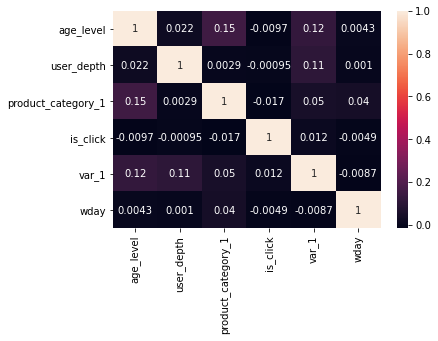

In [213]:
corrMatrix = df5.corr()
sns.heatmap(corrMatrix, annot=True)

# Model Fitting 

### Gaussian Naive Bayes

In [221]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_prob = gnb.fit(train_df[["wday","age_level","product"]], y_train).predict_proba(test_df[["wday","age_level","product"]])
y_pred = gnb.fit(train_df[["wday","age_level","product"]], y_train).predict(test_df[["wday","age_level","product"]])
accuracy_score(y_test,y_pred)

0.9335018537243006